In [23]:
# Assignment #7 - Sonia Garfinkel
# Cleaning up Midterm Notebook Assignment
# Discussing driving collisions. What are the factors that make collisions happen?
# I want to focus in more on MO codes, as well as demographic data

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx


In [3]:
col = pd.read_csv('2020_Collisions.csv')
#might decide to not use this dataset and move to the other data set

In [4]:
col15 = pd.read_csv('2015_2022_Collisions.csv')
#might only use this dataset

In [5]:
type(col15)
#col15 is a dataframe

pandas.core.frame.DataFrame

In [6]:
col15.head()
#shows first five lines of the dataset

,CASE_ID,VICTIM_AGE,VICTIM_SEX,NUMBER_KILLED,TYPE_OF_COLLISION,CITY,COLLISION_DATE,POINT_X,POINT_Y,geometry
0,90521190,41,M,0,Rear End,LOS ANGELES,2017-08-08,-118.387942,33.931320,POINT (-118.38794171 33.9313202)
1,90540575,64,M,0,Rear End,LOS ANGELES,2017-08-29,-118.381559,34.036448,POINT (-118.3815593 34.03644834)
2,90207168,51,M,0,Rear End,LOS ANGELES,2016-04-20,-118.221497,34.040282,POINT (-118.22149692 34.04028232)
3,90207168,51,M,0,Rear End,LOS ANGELES,2016-04-20,-118.221497,34.040282,POINT (-118.22149692 34.04028232)
4,90207168,51,M,0,Rear End,LOS ANGELES,2016-04-20,-118.221497,34.040282,POINT (-118.22149692 34.04028232)


In [7]:
col15.shape
#752180 rows, 10 columns. Meaning 752180 occurances of Traffic Collisions in West LA in between
# 2015-2022

(752180, 10)

In [8]:
col15.info

<bound method DataFrame.info of          CASE_ID  VICTIM_AGE VICTIM_SEX  NUMBER_KILLED   TYPE_OF_COLLISION  \
0       90521190          41          M              0            Rear End   
1       90540575          64          M              0            Rear End   
2       90207168          51          M              0            Rear End   
3       90207168          51          M              0            Rear End   
4       90207168          51          M              0            Rear End   
...          ...         ...        ...            ...                 ...   
752175   9561810           8          F              0            Rear End   
752176   9569884          31          -              0             Head-On   
752177   9570274          76          M              0          Hit Object   
752178   9570876          14          M              0  Vehicle/Pedestrian   
752179   9618143          24          M              0           Broadside   

               CITY COLLISION_D

In [9]:
col15.columns.to_list()
#See the column names

['CASE_ID',
 'VICTIM_AGE',
 'VICTIM_SEX',
 'NUMBER_KILLED',
 'TYPE_OF_COLLISION',
 'CITY',
 'COLLISION_DATE',
 'POINT_X',
 'POINT_Y',
 'geometry']

In [16]:
col.columns.to_list()

['DR Number',
 'Date Reported',
 'Date Occurred',
 'Time Occurred',
 'Area ID',
 'Area Name',
 'Reporting District',
 'Crime Code',
 'Crime Code Description',
 'MO Codes',
 'Victim Age',
 'Victim Sex',
 'Victim Descent',
 'Premise Code',
 'Premise Description',
 'Address',
 'Cross Street',
 'Latitude',
 'Longitude']

In [15]:
import folium 

In [19]:
col = gpd.GeoDataFrame(col, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(col.Longitude, col.Latitude))

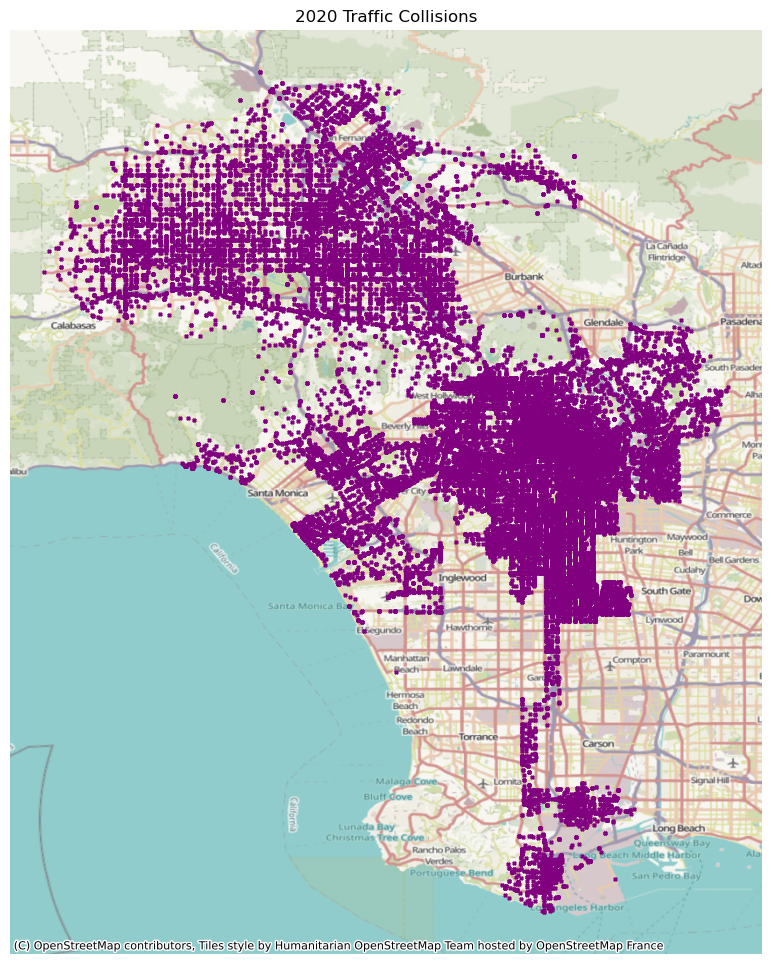

In [28]:
#Mapping the 2020 traffic collisions data onto the map

fig, ax = plt.subplots(figsize=(12,12))

#specifying the data marking options
ax = col.clip([-189,18,-66,71]).plot(ax=ax, 
        marker='X',
        markersize=5,
        color='purple')

ax.axis('off')

#set the title
ax.set_title('2020 Traffic Collisions')

ctx.add_basemap(ax, crs=4326)

#below shows all of the 2020 traffic collisions in LA

In [29]:
# Now I want to check out the other things in the data to see what is interesting
# Getting a count for Victim Descent in the data. 
col['Victim Descent'].value_counts()

#Shows lots of different decents, but at the top: 
# Hispanic = 17,238
# White = 7823
# Black = 6227

Victim Descent
H    17238
W     7823
B     6227
O     4796
X     3542
A     1210
K      249
F      133
C       72
J       28
V       25
I       21
U       18
Z       15
P       12
G        5
S        2
L        2
D        1
Name: count, dtype: int64

In [30]:
col['Victim Age'].value_counts()
# The most frequent victim age is 19 years old, at 3,804 victims
# The second most is 30 years old at 1,291 victims
# The third is 27

Victim Age
19.0    3804
30.0    1291
27.0    1078
25.0    1064
29.0    1059
        ... 
95.0       2
94.0       2
98.0       2
96.0       1
91.0       1
Name: count, Length: 89, dtype: int64

In [31]:
# Getting a count for MO Codes
col['MO Codes'].value_counts()

MO Codes
0605                                                 610
0605 3101 3401 3701 3006 3030                        577
3004 3028 3030 3035 3037 3101 3401 3701 4027         530
3006 3028 3030 3035 3037 3101 3401 3701 4027         517
3004 3037 3030 3028 3101 4026                        446
                                                    ... 
3006 3037 3602 3038 3026 3032 3101 4026                1
3003 3027 3032 3037 3102 4026                          1
3006 3028 3030 3035 3037 3401 3701 4020 3101           1
3006 4020 3028 3030 3035 3037 3101 3401 3701           1
3003 3029 3037 3101 3401 3701 4027 1402 3034 3027      1
Name: count, Length: 12281, dtype: int64

In [ ]:
# The most frequent MO Codes are:
# This is the most common set of MO Codes for a traffic collision, and their meanings:
# Source: https://data.lacity.org/api/views/d5tf-ez2w/files/8957b3b1-771a-4686-8f19-281d23a11f1b?download=true&filename=MO_CODES_Numerical_20180627.pdf

# 0605 = (Traffic Accident/Traffic related incident)   610
# 0605 3101 3401 3701 3006 3030                        577
# = 3101 (Primary Collsion Factor A In the Narriative)
# = 3401 (Type of Collision)
# = 3701 (Movement Preceding Collision)
# = 3006 (Veh vs Parked Veh)
# = 3030 (Hit and Run Misd)

#This all shows that the second most frequent type of crash is:
# A vehicle hitting a parked vehicle, and it being a hit and run

# It also shows that every traffic violation looks a little different with every single MO code


In [32]:
# function
def mo_codes(place):
    # code to create the MO code 

# list of attributes
attributes = ['Reporting District','Crime Code','MO Codes', 'Victim Age', 'Victim Descent',]

# call the function with a loop
for attributes in attributes:
    mo_codes(place=attributes)

#This didnt work 

IndentationError: expected an indented block after function definition on line 2 (3590881946.py, line 6)